<a href="https://colab.research.google.com/github/fendy07/FMNIST-DeepLearning/blob/master/ML_01_FendyHendriyanto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fashion MNIST Classification Using CNN and RNN-LSTM Algorithm**

In [2]:
!pip install -q visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 9.0 MB/s eta 0:00:00


# 1) **Exploring The Dataset**
## 1.1) **Importing Libraries**

Memasukan Library yang akan digunakan dalam proses Deep Learning mulai dari memasukan data sampai proses evaluasi model data.

In [3]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')
# Handle table-like data and matrices :
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Modelling Helpers :
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# Deep Learning Libraries
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

## 1.2) **Mengekstraksi Dataset**

a. Menyambungkan data dari Google Drive

b. Memasukan data csv dengan Pandas


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mnist_train = pd.read_csv('/content/drive/MyDrive/Proyek/Computer Vision/Fashion-MNIST/Dataset/fashion-mnist_train.csv')
mnist_test = pd.read_csv('/content/drive/MyDrive/Proyek/Computer Vision/Fashion-MNIST/Dataset/fashion-mnist_test.csv')

## 1.3) Combine Dataset

Kombinasi data yang awalnya terpisah dari data train dan data test sehingga yang awalnya berjumlah 60000 pada data train dan 10000 pada data test. Sehingga, keseluruhan data berjumlah 70000 dataset.

In [5]:
combine = [mnist_train, mnist_test]
fmnist = pd.concat(combine)

In [7]:
fmnist

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,151,168,...,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,...,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,0,1,3,0,14,152,184,158,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,219,223,226,239,247,241,224,213,144,0,0,0,0,0,0,1,0,44,232,199,200,190,180,179,185,189,191,185,179,178,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,131,192,79,0,0,0,0,...,13,26,17,8,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 1.4) Check Data NaN

Memeriksa data NaN secara keseluruhan

In [8]:
fmnist.isnull().any().sum()

0

# 2) Visualizing the Dataset
## 2.1) Melihat Bentuk data beserta label

In [9]:
x_data = fmnist.copy()
y_data = x_data.pop('label').values
x_data = np.array(x_data).reshape(-1, 28, 28) / 255.0

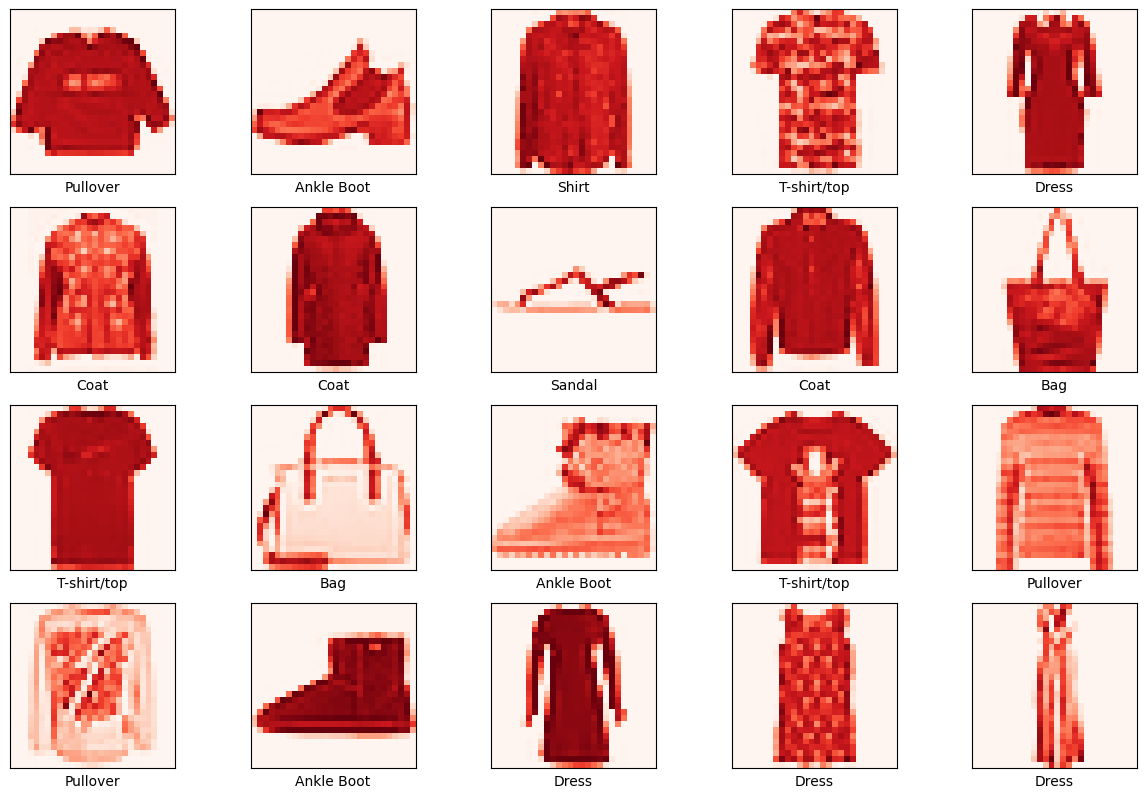

In [10]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

plt.figure(figsize=(15, 15))
for i in range(20):
  plt.subplot(6,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_data[i], cmap='Reds')
  plt.xlabel(labeldict[y_data[i]])
plt.show()

# 3) Data PreProcessing
## 3.1) Membagi data menjadi 2 bagian yaitu data train dan data test

In [11]:
x_fmnist = fmnist.drop(['label'], axis=1).values
y_fmnist = fmnist['label'].values

Memeriksa jumlah data train dan data test

In [12]:
pers_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(x_fmnist, y_fmnist, test_size= pers_test, random_state=25)

print("Data training (image) shape: {shape}".format(shape=X_train.shape))
print("Data testing (image) shape: {shape}".format(shape=X_test.shape))
print("Data training (label) shape: {shape}".format(shape=y_train.shape))
print("Data testing (label) shape: {shape}".format(shape=y_test.shape))

Data training (image) shape: (56000, 784)
Data testing (image) shape: (14000, 784)
Data training (label) shape: (56000,)
Data testing (label) shape: (14000,)


## 3.2) **Membentuk Ulang Data Citra**

Data gambar diubah menjadi ukuran 28x28 pixel dengan cara `reshape` atau membentuk ulang menyesuaikan dengan data piksel gambar dan citra negatif dengan parameter `-1`


In [13]:
# Reshape the Image
x_n = 28
x_train_pic = X_train.reshape((-1, x_n, x_n, 1))
x_test_pic = X_test.reshape((-1, x_n, x_n, 1))
print(x_train_pic.shape, x_test_pic.shape)

(56000, 28, 28, 1) (14000, 28, 28, 1)


## 3.3) Normalisasi Data

Nilai pixel disimpan dalam bentuk angka (Integer) dalam nilai antara  0 sampai 255, kisaran yang dapat ditawarkan oleh single 8-bit byte.  Dibutuhkan algoritma optimasi bekerja cepat. Disini, Menggunakan Zero Mean dan Variance Unit.

In [14]:
# Normalisasi
x_train_pic = x_train_pic.astype("float32")/255
x_test_pic = x_test_pic.astype("float32")/255

## 3.4) One Hot Encoding
Label diberikan sebagai bilangan bulat antara 0-9. Kita perlu one hot encode.

Misalnya,

8 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

5 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [15]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 4) Melatih sebuah model Convolutional Neural Network
## 4.1) Membangun sebuah Model ConvNet
Langkah:

1) Pada awalnya, menggunakan Sequential Keras API yang hanya setumpuk linear lapisan. Kami menambahkan satu lapisan pada satu waktu mulai dari input.

2) Selanjutnya, menambahkan Lapisan Konvolusional, yang merupakan blok Bangunan dari ConvNets. Lapisan Konvolusional memiliki seperangkat Filter independen yang kedalamannya sama dengan input dan dimensi lain dapat diatur secara manual. Filter-filter ini ketika mengkonvolusi yang berlebihan dari masukan Gambar menghasilkan feature map.

3) Selanjutnya, menambahkan **Pooling Layers**, yang digunakan untuk Pengurangan Dimensi atau DownSampling. Ini digunakan di mana memiliki banyak fitur Input. Ini mengurangi jumlah Parameter dan daya komputasi yang dibutuhkan secara drastis, sehingga mengurangi Overfitting. Lapisan ini bersama dengan lapisan Konvolusional dapat mempelajari lebih banyak fitur Kompleks Gambar

4) Kami menambahkan Normalisasi Batch di mana kami mencapai Zero mean dan Variance one. Ini mengurangi pencilan dan memaksa jaringan untuk mempelajari fitur dengan cara terdistribusi, tidak terlalu bergantung pada Bobot Khusus dan membuat model ini lebih baik.

5) Untuk menghindari Overfitting, kami menambahkan **Dropout**. Ini secara acak turun beberapa persen dari neuron, dan dengan demikian bobot akan diselaraskan kembali. Neuron yang tersisa mempelajari lebih banyak fitur dan ini mengurangi ketergantungan pada salah satu Neuron. DropOut adalah Teknik Regularisasi, yang Menghukum Parameter. Secara umum, kami menetapkan **DropOutRate** antara 0,2 - 0,5.

6) Akhirnya kami menambahkan layer Ratakan untuk memetakan input ke vektor 1D. Kami kemudian menambahkan Layers sepenuhnya terhubung setelah beberapa lapisan convolutional / pooling. Ini menggabungkan semua Fitur dari Lapisan Sebelumnya.

7) Terakhir, kami menambahkan **Layer Output**. Ini memiliki unit yang sama dengan jumlah kelas yang akan diidentifikasi. Di sini, kami menggunakan fungsi 'sigmoid' jika itu adalah Klasifikasi Biner sebaliknya fungsi aktivasi 'softmax' dalam kasus Klasifikasi Multi-Kelas.

In [16]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides= 2))
model.add(Dropout(rate=0.2))
model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

## 4.3) Model Summary

Rangkuman model yang dibuat berisi layer atau lapisan output dan parameter.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

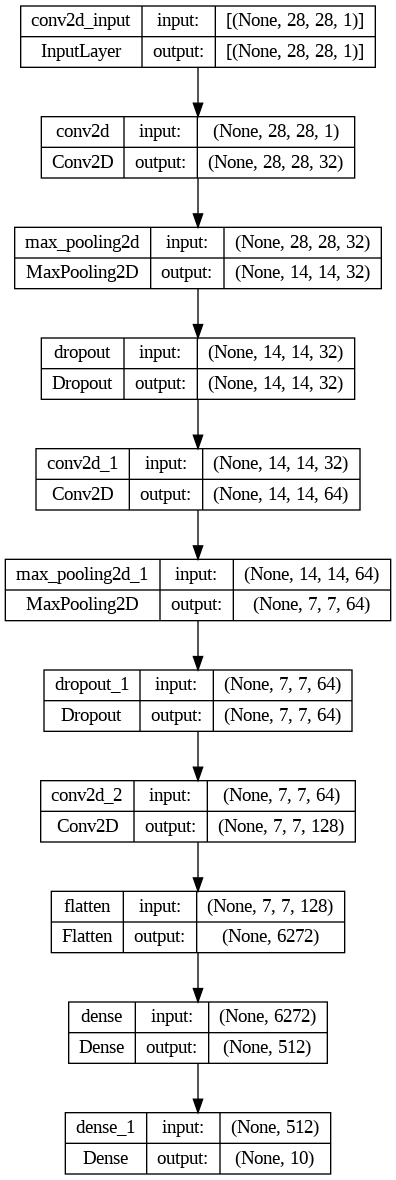

In [19]:
import tensorflow as tf
from keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

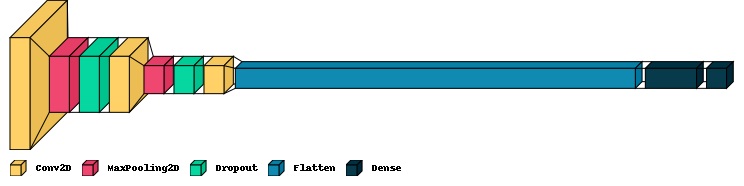

In [22]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file='output.png')

## 4.2) Compiling the Model

1) Kita perlu menyusun sebuah model. Kita harus menemtukan pengoptimalkan yang diperlukan oleh model. Kami memiliki banyak pilihan seperti Adam, RMSprop dll.
2) Selanjutnya, kita membutuhkan spesifikasi fungsi Loss untuk Jaringan Syaraf Tiruan yang kita minimalkan. Untuk klasifikasi biner menggunakan "binary_crossentropy" dan untuk klasifikasi multi kelas menggunakan "categorical_crossentropy".
3) Akhirnya, kita menentukan metrik untuk mengevaluasi model yang kita buat.

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4.5) Data Augmentation

Augmentasi data gambar digunakan untuk memanipulasi data dengan cara merotasi gambar,memperbesar gambar, memotong gambar, membalikan gambar tanpa menghilangkan inti dari data tersebut.

In [24]:
# Data Augmentation
datagen = ImageDataGenerator(
        rotation_range = 8,       # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,         # Randomly zoom image
        shear_range = 0.3,        # shear angle in counter-clockwise direction in degrees
        width_shift_range = 0.08,   # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip = True)       # randomly flip images

In [25]:
datagen.fit(x_train_pic)

## 4.6) Fitting the Model

Membuat pemasangan model sesuai batch_size dan epoch yang dipilih.

In [26]:
# Fitting the Model
BATCH_SIZE = 512
EPOCHS = 50

In [27]:
# Fit the Model data
history = model.fit(datagen.flow(x_train_pic, y_train, batch_size = BATCH_SIZE),
                              epochs = EPOCHS,
                              validation_data = (x_test_pic, y_test),
                              verbose=2,
                              steps_per_epoch = x_train_pic.shape[0] // BATCH_SIZE)

Epoch 1/50
109/109 - 32s - loss: 0.9429 - accuracy: 0.6389 - val_loss: 0.5700 - val_accuracy: 0.7828 - 32s/epoch - 298ms/step
Epoch 2/50
109/109 - 18s - loss: 0.6378 - accuracy: 0.7579 - val_loss: 0.4842 - val_accuracy: 0.8178 - 18s/epoch - 162ms/step
Epoch 3/50
109/109 - 19s - loss: 0.5643 - accuracy: 0.7862 - val_loss: 0.4663 - val_accuracy: 0.8214 - 19s/epoch - 174ms/step
Epoch 4/50
109/109 - 18s - loss: 0.5251 - accuracy: 0.8016 - val_loss: 0.4531 - val_accuracy: 0.8256 - 18s/epoch - 165ms/step
Epoch 5/50
109/109 - 20s - loss: 0.4870 - accuracy: 0.8175 - val_loss: 0.3840 - val_accuracy: 0.8618 - 20s/epoch - 182ms/step
Epoch 6/50
109/109 - 18s - loss: 0.4570 - accuracy: 0.8282 - val_loss: 0.3751 - val_accuracy: 0.8619 - 18s/epoch - 163ms/step
Epoch 7/50
109/109 - 17s - loss: 0.4379 - accuracy: 0.8362 - val_loss: 0.3560 - val_accuracy: 0.8659 - 17s/epoch - 159ms/step
Epoch 8/50
109/109 - 19s - loss: 0.4196 - accuracy: 0.8436 - val_loss: 0.3677 - val_accuracy: 0.8576 - 19s/epoch - 174

# 5) Evaluating the Model

Mengevaluasi model data menggunakan tes akurasi dan tes loss.

In [28]:
score = model.evaluate(x_test_pic, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

438/438 [==============================] - 1s 3ms/step - loss: 0.2635 - accuracy: 0.9049
Loss: 0.2635
Accuracy: 0.9049


## 5.1) Plotting the Training and Validation Curves

Menampilkan plot data train dan test yang dihasilkan dari sebuah metode yang digunakan.

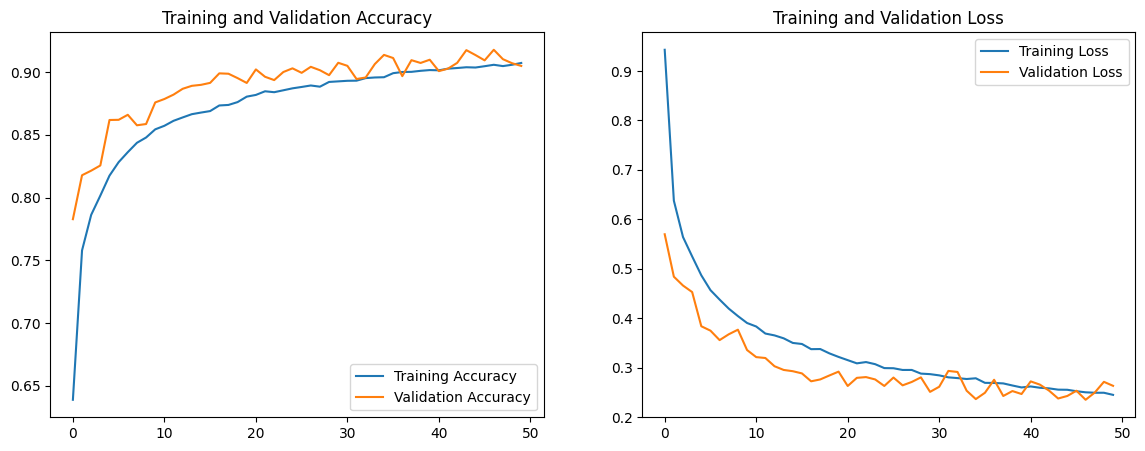

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Kurva Pelatihan dan Validasi sudah dekat, kita dapat menyimpulkan bahwa Model tidak Kelebihan Data.**

# 6) Confusion Matrix

Confusion Matrix digunakan untuk mencari performa dalam memprediksi hasil data dengan data aktual.

438/438 [==============================] - 1s 2ms/step


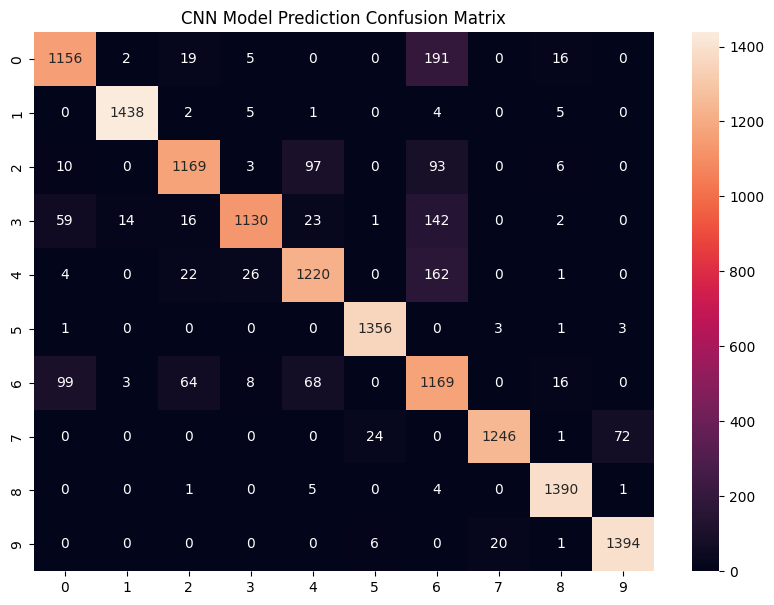

In [31]:
# Get Model Predictions for test data
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

predicted_classes = model.predict(x_test_pic)
Y_pred_classes = np.argmax(predicted_classes, axis=1)
Y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("CNN Model Prediction Confusion Matrix")
plt.show()

# 7) Visualization of Predicted Classes
## 7.1) Correctly Predicted Classes

Visualisasi hasil data prediksi yang benar dalam sebuah label data berdasarkan kelas.

In [32]:
# Correctly Predicted Classes
correct = []
for i in range(len(y_test)):
  if(Y_pred_classes[i] == Y_true[i]):
    correct.append(i)
  if(len(correct) == 4):
    break

Text(0.5, 1.0, 'Predicted Label : Dress\nActual Label : Dress')

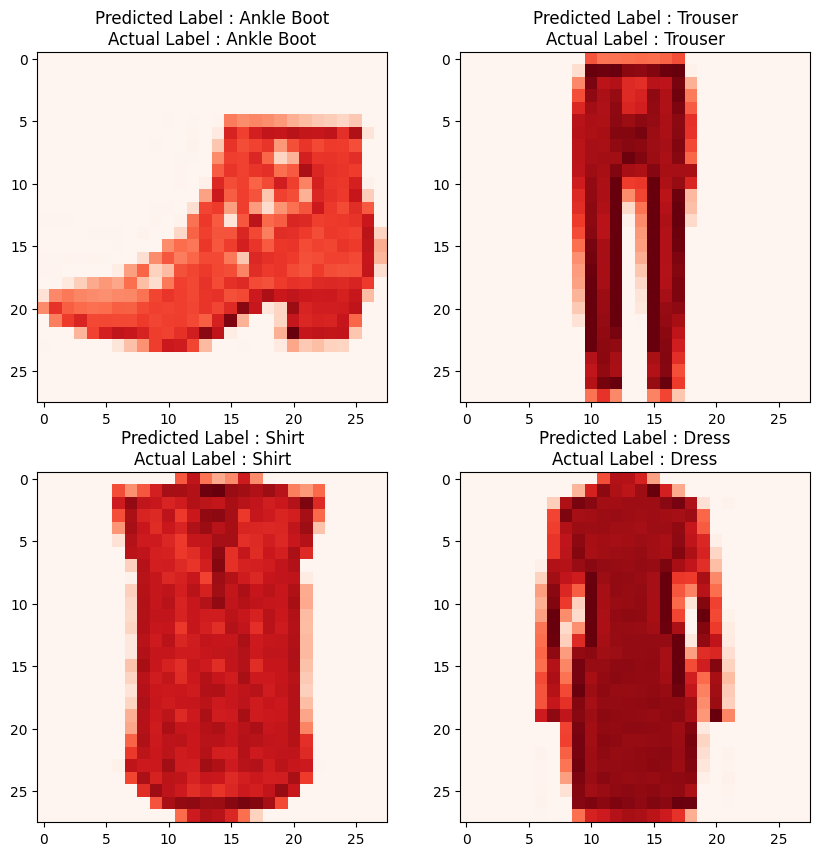

In [33]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)

ax[0,0].imshow(X_test[correct[0]].reshape(28,28), cmap='Reds')
ax[0,0].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[correct[0]]]))

ax[0,1].imshow(X_test[correct[1]].reshape(28,28), cmap='Reds')
ax[0,1].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[correct[1]]]))

ax[1,0].imshow(X_test[correct[2]].reshape(28,28), cmap='Reds')
ax[1,0].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[correct[2]]]))

ax[1,1].imshow(X_test[correct[3]].reshape(28,28), cmap='Reds')
ax[1,1].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[correct[3]]]))

## 7.2) Incorrectly Predicted Classes

Visualisasi dari hasil prediksi data yang salah dari label data berdasarkan kelas

In [34]:
# Incorrectly Predicted Classes
incorrect = []
for i in range(len(y_test)):
  if(not Y_pred_classes[i] == Y_true[i]):
    incorrect.append(i)
  if(len(incorrect) == 4):
    break

Text(0.5, 1.0, 'Predicted Label : Shirt\nActual Label : T-shirt/top')

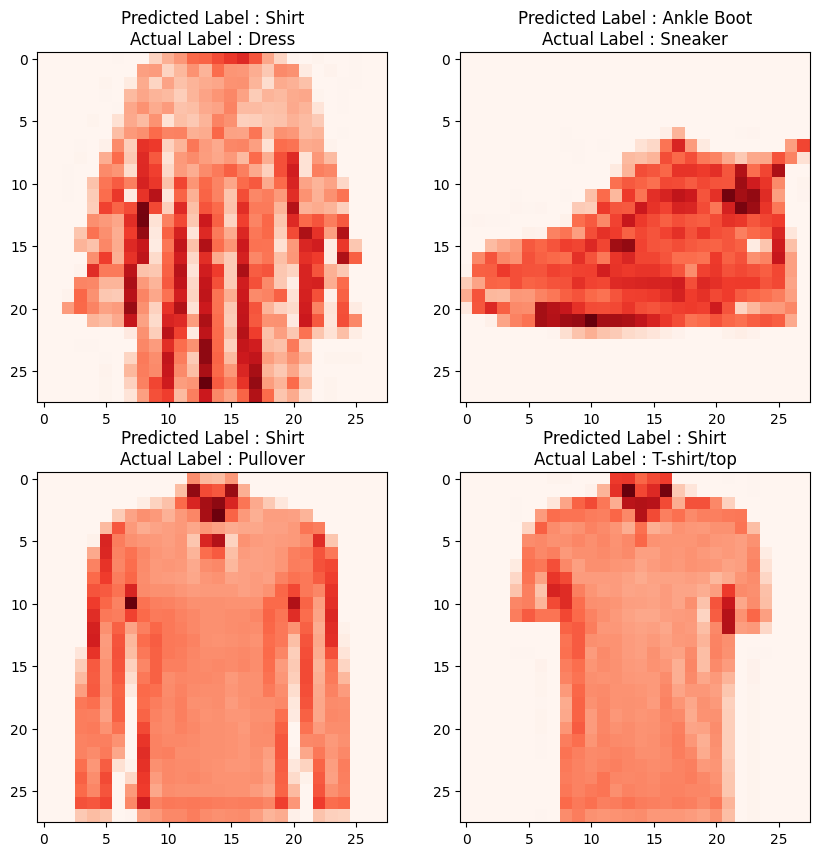

In [35]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)

ax[0,0].imshow(X_test[incorrect[0]].reshape(28,28), cmap='Reds')
ax[0,0].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[incorrect[0]]]))

ax[0,1].imshow(X_test[incorrect[1]].reshape(28,28), cmap='Reds')
ax[0,1].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[incorrect[1]]]))

ax[1,0].imshow(X_test[incorrect[2]].reshape(28,28), cmap='Reds')
ax[1,0].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[incorrect[2]]]))

ax[1,1].imshow(X_test[incorrect[3]].reshape(28,28), cmap='Reds')
ax[1,1].set_title("Predicted Label : " + str(labeldict[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " +
                 str(labeldict[Y_true[incorrect[3]]]))

# 8) Classification Report

Classification Report digunakan untuk menampilkan Presisi, Recall dan F1-Score dan Nilai Support.

In [36]:
print(classification_report(Y_true, Y_pred_classes, target_names = class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.83      0.85      1389
     Trouser       0.99      0.99      0.99      1455
    Pullover       0.90      0.85      0.88      1378
       Dress       0.96      0.81      0.88      1387
        Coat       0.86      0.85      0.86      1435
      Sandal       0.98      0.99      0.99      1364
       Shirt       0.66      0.82      0.73      1427
     Sneaker       0.98      0.93      0.95      1343
         Bag       0.97      0.99      0.98      1401
  Ankle boot       0.95      0.98      0.96      1421

    accuracy                           0.90     14000
   macro avg       0.91      0.90      0.91     14000
weighted avg       0.91      0.90      0.91     14000



**Lihatlah Presisi shirt, kita dapat melihat bahwa model kami memperkirakan kurang dari 80% Kaos dengan benar dari total gambar yang diprediksi shirt. Kami menyimpulkan hal yang sama dari matriks kebingungan, di mana kami melihat bahwa banyak T-shirt salah diklasifikasikan sebagai T-Shirt.**

# 9.) **Rekapitulasi Data**

Rekapitulasi digunakan untuk menampilkan hasil evaluasi model data dengan variasi parameter yang digunakan.

In [39]:
evaluation = pd.DataFrame({'Model': [],
                           'Data_Train': [],
                           'Data_Test': [],
                           'Epochs': [],
                           'Batch_size':[],
                           'Loss': [],
                           'Accuracy': []
                           })

In [40]:
r = evaluation.shape[0]
evaluation.loc[r] = ['CNN', str(1 - pers_test), str(pers_test), EPOCHS, BATCH_SIZE, score[0], score[1]]
evaluation

,Model,Data_Train,Data_Test,Epochs,Batch_size,Loss,Accuracy
0,CNN,0.8,0.2,50,512,0.263525,0.904857


# **Recurrent Neural Network**

## **Import Library**


In [41]:
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM

## **Inisialisasi Parameter**

Inisialisasi parameter mendefinisikan parameter yang akan digunakan untuk melatih model data.

In [42]:
# Training parameters.
batch_size = 32
num_classes = 10
epochs = 10

# Embedding dimensions.
row_hidden = 128
col_hidden = 128

# Converts class vectors to binary class matrices.
row, col, pixel = x_train_pic.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

Encode Data

Encode Data digunakan untuk mengubah data baris dan kolom menggunakan metode LSTM (Long-Short Time Memory).

In [43]:
# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)
# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

Membangun Model Data

In [44]:
# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

## **Melatih Model Data**

In [45]:
# Fitting the model
model.fit(x_train_pic, y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_test_pic, y_test),
          shuffle = False)

Epoch 1/10
1750/1750 [==============================] - 32s 16ms/step - loss: 0.7409 - accuracy: 0.7262 - val_loss: 0.5105 - val_accuracy: 0.8133
Epoch 2/10
1750/1750 [==============================] - 27s 16ms/step - loss: 0.4575 - accuracy: 0.8317 - val_loss: 0.4399 - val_accuracy: 0.8391
Epoch 3/10
1750/1750 [==============================] - 20s 12ms/step - loss: 0.3842 - accuracy: 0.8585 - val_loss: 0.3818 - val_accuracy: 0.8584
Epoch 4/10
1750/1750 [==============================] - 23s 13ms/step - loss: 0.3461 - accuracy: 0.8701 - val_loss: 0.3585 - val_accuracy: 0.8702
Epoch 5/10
1750/1750 [==============================] - 21s 12ms/step - loss: 0.3186 - accuracy: 0.8805 - val_loss: 0.3544 - val_accuracy: 0.8700
Epoch 6/10
1750/1750 [==============================] - 20s 11ms/step - loss: 0.2952 - accuracy: 0.8898 - val_loss: 0.3288 - val_accuracy: 0.8808
Epoch 7/10
1750/1750 [==============================] - 21s 12ms/step - loss: 0.2788 - accuracy: 0.8954 - val_loss: 0.3223 -

## **Evaluasi Data**

In [46]:
# Evaluation.
scores = model.evaluate(x_test_pic, y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

438/438 [==============================] - 3s 6ms/step - loss: 0.3111 - accuracy: 0.8882
Test loss: 0.3111443817615509
Test accuracy: 0.8882142901420593


In [47]:
# Get Model Predictions for test data
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

predicted_classes = model.predict(x_test_pic)
Y_pred_classes = np.argmax(predicted_classes, axis=1)
Y_true = np.argmax(y_test, axis = 1)
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

438/438 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.87      0.85      1389
     Trouser       0.99      0.97      0.98      1455
    Pullover       0.72      0.90      0.80      1378
       Dress       0.85      0.95      0.90      1387
        Coat       0.87      0.70      0.77      1435
      Sandal       0.99      0.97      0.98      1364
       Shirt       0.80      0.66      0.72      1427
     Sneaker       0.97      0.91      0.94      1343
         Bag       0.98      0.97      0.97      1401
  Ankle boot       0.92      0.98      0.95      1421

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



## **Confusion Matrix**

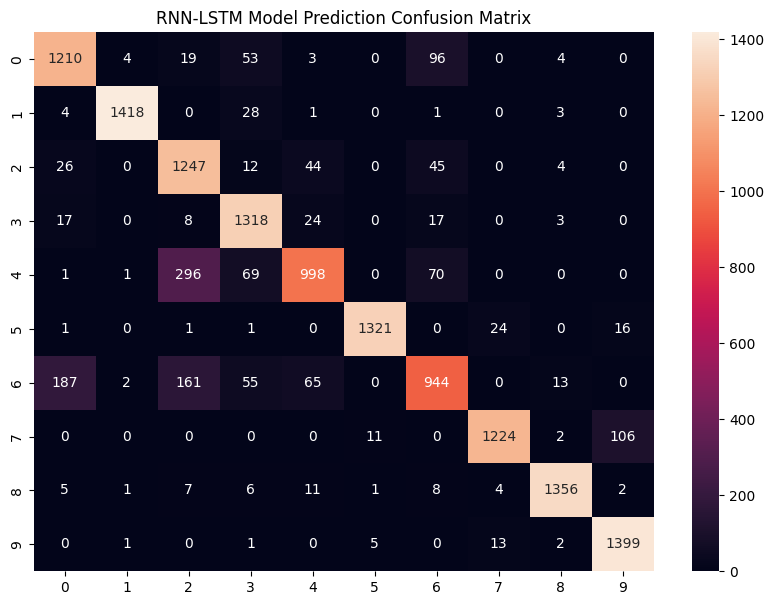

In [48]:
# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("RNN-LSTM Model Prediction Confusion Matrix")
plt.show()

438/438 [==============================] - 2s 5ms/step


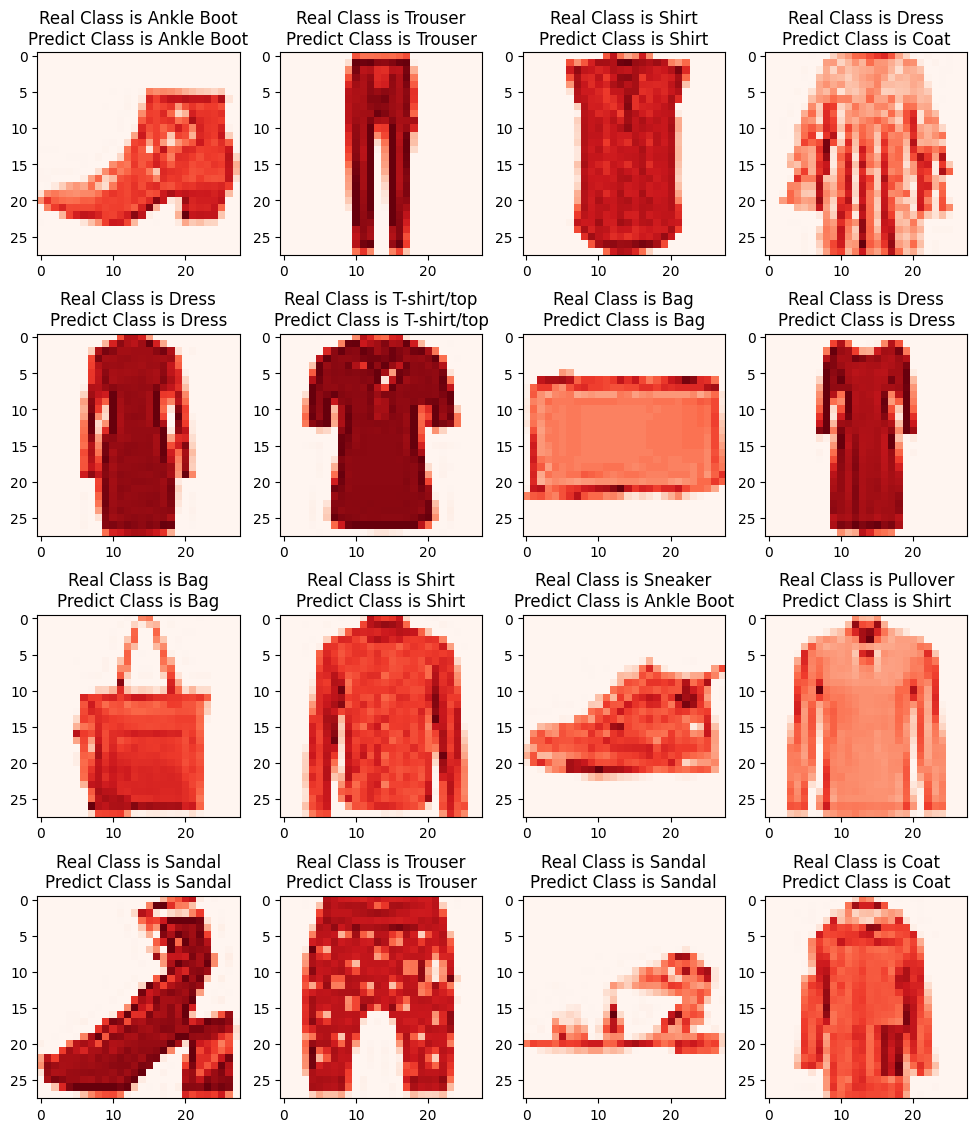

In [49]:
labels = {0 : "T-shirt/top",
          1: "Trouser",
          2: "Pullover",
          3: "Dress",
          4: "Coat",
          5: "Sandal",
          6: "Shirt",
          7: "Sneaker",
          8: "Bag",
          9: "Ankle Boot"}

y_pred = model.predict(x_test_pic)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='Reds')
    ax.set(title = f"Real Class is {labels[y_test[i].argmax()]}\nPredict Class is {labels[y_pred[i].argmax()]}");

In [50]:
r = evaluation.shape[0]
evaluation.loc[r] = ['RNN-LSTM', str(1 - pers_test), str(pers_test), epochs, batch_size, scores[0], scores[1]]
evaluation

,Model,Data_Train,Data_Test,Epochs,Batch_size,Loss,Accuracy
0,CNN,0.8,0.2,50,512,0.263525,0.904857
1,RNN-LSTM,0.8,0.2,10,32,0.311144,0.888214


Memasukan hasil dari kinerja model data kedalam CSV dengan Pandas

In [52]:
dict = {"Model" : evaluation.Model,
        "Data Train" : evaluation.Data_Train,
        "Data Test" : evaluation.Data_Test,
        "Epochs" : evaluation.Epochs,
        "Batch Size" : evaluation.Batch_size,
        "Loss" : evaluation.Loss,
        "Accuracy" : evaluation.Accuracy
        }

df = pd.DataFrame(dict)
# Save to Drive for CSV data
df.to_csv(r"/content/drive/MyDrive/Proyek/Computer Vision/Fashion-MNIST/hasil_model.csv", index=False)

In [53]:
# Save the model
model.save('model-rnn.h5')
print('Save Model Success!')

Save Model Success!
